### This time I am submitting my code in ipython notebook instead of main.py file. This notebook will walk you through all the functions and actually computations I displayed on the website

import libraries

In [66]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import glob
from skimage.filters import roberts
import skimage.data as data
import scipy
import matplotlib.pyplot as plt
import cv2

helper functions from project1

In [59]:

def split_im(image):
    height = np.floor(image.shape[0]/3.0).astype(np.int)
    image1 = image[:height]
    image2 = image[height:2*height]
    image3 = image[2*height:3*height]
    return image1, image2, image3

def show_im(im):
    skio.imshow(im)
    skio.show()
    
def crop_im(im, percentage):
    """
    crop the image in all four sides by <n> pixels
    """
    height = im.shape[0]
    width = im.shape[1]
    n = int(height*percentage)
    m = int(width*percentage)
    return im[n:-n, m:-m]   

def crop_im_abs(im, dim):
    h = dim[0]
    w = dim[1]
    return im[h:-h, w:-w]

def resize_im(im, factor):
    size = (np.array(im.shape) * factor).astype(int)
    res_im = sktr.resize(im, size, order = 3)
    return res_im

def shift_im(im, right, down):
    im = np.roll(im, right, axis = 1)
    im = np.roll(im, down, axis = 0)
    return im

def read_im(im):
    im = skio.imread(im)
    return im

def stack_channel(R, G, B):
    im_stacked = np.stack(np.asarray([B, G, R]), axis = 2)
    return im_stacked 

def normalize(im):
    im = im - np.min(im)
    return im/(np.max(im)-np.min(im))

## Part 1.1: Finite Difference Operator

helper functions for this part

In [61]:
def compute_grad_mag(Dx, Dy):
    grad_mag = np.sqrt(Dx**2 + Dy**2)
    return normalize(grad_mag)
def dx_filter(im):
    """
    compute the Dx of the image
    
    """
    Dx = np.array([[1, -1]])
    filtered = scipy.signal.convolve2d(im, Dx, mode = "same")
    return filtered
def dy_filter(im):
    """
    compute the Dy of the image
    
    """
    
    Dy = np.array([[1], [-1]])
    filtered = scipy.signal.convolve2d(im, Dy, mode = "same")
    return filtered

def grad_to_edge(threshold=0.15, grad_im = None):
    
    """
    binarizes the gradient magnitude image
    """
    boolean_array = grad_im > threshold
    zero_one_array = boolean_array.astype(np.int)
    
    return zero_one_array

We do convolution on the cameraman image

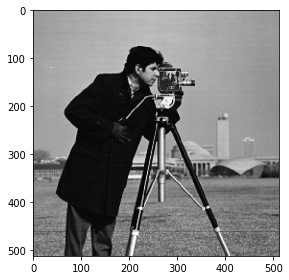

In [62]:
im = sk.data.camera()
show_im(im)

convoluting Dx

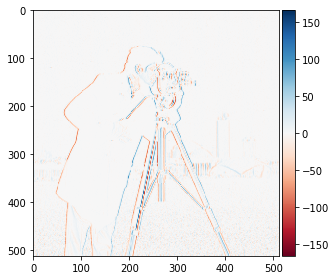

In [63]:
filtered_hori = dx_filter(im)
show_im(filtered_hori)

Convoluting Dy

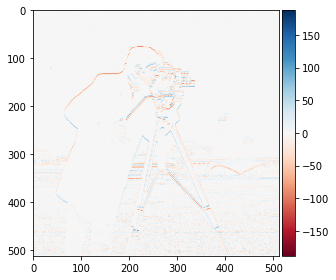

In [64]:
filtered_vert = dy_filter(im)
show_im(filtered_vert)

Then we combine dy and dx to compute the gradient magnitude, and then thresholding

/Users/princewang/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


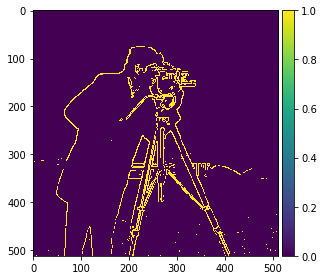

In [65]:
grad_im = compute_grad_mag(filtered_hori, filtered_vert)
binarized_im = grad_to_edge(grad_im = grad_im)
show_im(binarized_im)

## Part 1.2: Derivative of Gaussian (DoG) Filter

Helper functions for this part

In [67]:
def generate_gaussian_filter(ksize, sigma):
    kernel1d = cv2.getGaussianKernel(ksize, sigma)
    kernel1d_T = kernel1d_T = np.transpose(kernel1d)
    return np.outer(kernel1d, kernel1d_T)
def gaussian_filter(im, ksize, sigma):
    gaussian = generate_gaussian_filter(ksize, sigma)
    gaus_im = scipy.signal.convolve2d(im, gaussian, mode = "same")
    return gaus_im
def gaussian_filter_color(im, ksize, sigma):
    imb, img, imr = cv2.split(im)
    imb_blur = gaussian_filter(imb, ksize, sigma)
    img_blur = gaussian_filter(img, ksize, sigma)
    imr_blur = gaussian_filter(imr, ksize, sigma)
    return stack_channel(imr_blur, img_blur, imb_blur)

def filter_im_gaussian(im):
    gaussian_filter = generate_gaussian_filter(12, 2)
    gaus_im = scipy.signal.convolve2d(im, gaussian_filter, mode = "same")
    
    Dx = np.array([[1, -1]])
    Dy = np.array([[1], [-1]])
    
    filtered_hori = scipy.signal.convolve2d(gaus_im, Dx, mode = "same")
    filtered_vert = scipy.signal.convolve2d(gaus_im, Dy, mode = "same")
    
    grad_im = compute_grad_mag(filtered_hori, filtered_vert)
    normalized_grad = normalize(grad_im)
    
    return normalized_grad

Again using the cameraman image, this time we filter it with a DoG filter

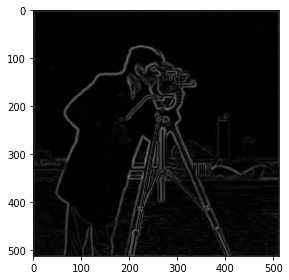

In [70]:
im_Gaus = filter_im_gaussian(im)
show_im(im_Gaus)

## Part 1.3: Image Straightening
helper functions for this part

In [71]:
def compute_grad_angle(im):
    Dy = dy_filter(im)
    Dx = dx_filter(im) + 0.0001
    dy_over_dx = Dy/Dx
    grad_directions = np.arctan(Dy/Dx)
    return grad_directions

def count_horizontal(im, epsilon = np.pi/180):
    imf = im.flatten()
    result1 = imf < epsilon
    result2 = imf > -epsilon
    result12 = result1 & result2
    
    result3 = imf < np.pi + epsilon
    result4 = imf > np.pi - epsilon
    result34 = result3 & result4
    
    result = np.logical_or(result12, result34)
    return np.sum(result)

def count_vertical(im, epsilon = np.pi/180):
    half_pi = np.pi/2
    imf = im.flatten()
    result1 = imf < half_pi + epsilon
    result2 = imf > half_pi - epsilon
    result12 = result1 & result2
    
    result3 = imf < half_pi + epsilon
    result4 = imf > half_pi - epsilon
    result34 = result3 & result4
    
    result = np.logical_or(result12, result34)
    return np.sum(result)
def num_ver_hori(im, angle):
    im = scipy.ndimage.interpolation.rotate(im, angle)
    im = crop_im(im, 0.3)
    im = sk.color.rgb2gray(im)
    im = gaussian_filter(im, 5,2)
    grad_angle = compute_grad_angle(im)
    
    
    line1 = grad_angle < 0.1
    line2 = grad_angle > -0.1
    line3 = np.logical_and(line1,line2)
    
    line4 = (-1.58 < grad_angle) & (grad_angle < -1.56)
    line5 = (1.56 < grad_angle) & (grad_angle < 1.58)
    line6 = np.logical_or(line4,line5)
    
    total = np.sum(line6) + np.sum(line3)
    pixels = im.shape[0]*im.shape[1]
    
    return total/pixels

def auto_rotate(im):
    best_ratio = 0
    best_angle_now = 0
    for angle in np.arange(-10,10,2):
        ratio = num_ver_hori(im, angle)
        if ratio > best_ratio:
            best_ratio = ratio
            best_angle_now = angle
    print(best_angle_now)
    return scipy.ndimage.interpolation.rotate(im, best_angle_now)

auto_rotate is our function for auto straightening. We run this function on our facade image, it prints out the best rotation angle in degree, and then returns a rotated version of the image

-2


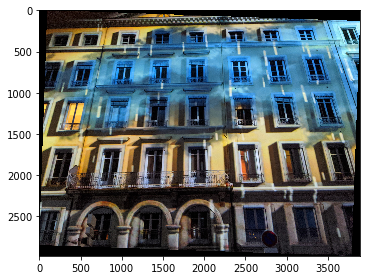

In [72]:
facade = read_im("./demo/facade.jpg")
facade_rotated = auto_rotate(facade)
show_im(facade_rotated)

We plot the histogram for the gradient directions in this rotated version of the image

(array([ 394173.,  180785.,  180629.,  194369.,  169692.,  180473.,
         151373.,  205100.,  145518.,  156589.,  145943.,  133687.,
         270932.,  134322.,  150022.,  159896.,  149652.,  208562.,
         162327.,  190278.,  165983.,  201258.,  183912.,  186225.,
         158261., 1459006.,  195731.,  200511.,  233751.,  196940.,
         236324.,  211264.,  276262.,  206036.,  225002.,  214045.,
         193143.,  393391.,  191996.,  211768.,  228065.,  206689.,
         277498.,  205911.,  236073.,  213003.,  236880.,  210630.,
         197882.,  392318.]),
 array([-1.57076846e+00, -1.50793930e+00, -1.44511013e+00, -1.38228097e+00,
        -1.31945181e+00, -1.25662264e+00, -1.19379348e+00, -1.13096431e+00,
        -1.06813515e+00, -1.00530598e+00, -9.42476817e-01, -8.79647653e-01,
        -8.16818488e-01, -7.53989323e-01, -6.91160159e-01, -6.28330994e-01,
        -5.65501829e-01, -5.02672665e-01, -4.39843500e-01, -3.77014336e-01,
        -3.14185171e-01, -2.51356006e-01, -1.8

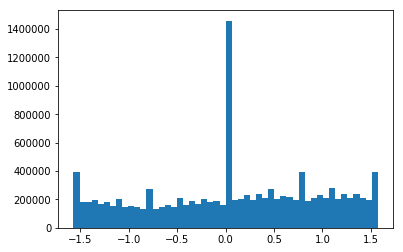

In [40]:
plt.hist(compute_grad_angle(sk.color.rgb2gray(facade_rotated)).flatten(), bins = 50)

We do the same thing for some other images of our selection

6


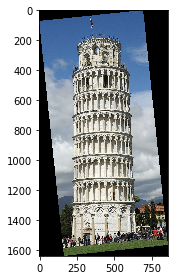

In [74]:
pisa = read_im("./demo/pisa.jpg")[:,:,:3]
pisa_rotated = auto_rotate(pisa)
show_im(pisa_rotated)

(array([ 394173.,  180785.,  180629.,  194369.,  169692.,  180473.,
         151373.,  205100.,  145518.,  156589.,  145943.,  133687.,
         270932.,  134322.,  150022.,  159896.,  149652.,  208562.,
         162327.,  190278.,  165983.,  201258.,  183912.,  186225.,
         158261., 1459006.,  195731.,  200511.,  233751.,  196940.,
         236324.,  211264.,  276262.,  206036.,  225002.,  214045.,
         193143.,  393391.,  191996.,  211768.,  228065.,  206689.,
         277498.,  205911.,  236073.,  213003.,  236880.,  210630.,
         197882.,  392318.]),
 array([-1.57076846e+00, -1.50793930e+00, -1.44511013e+00, -1.38228097e+00,
        -1.31945181e+00, -1.25662264e+00, -1.19379348e+00, -1.13096431e+00,
        -1.06813515e+00, -1.00530598e+00, -9.42476817e-01, -8.79647653e-01,
        -8.16818488e-01, -7.53989323e-01, -6.91160159e-01, -6.28330994e-01,
        -5.65501829e-01, -5.02672665e-01, -4.39843500e-01, -3.77014336e-01,
        -3.14185171e-01, -2.51356006e-01, -1.8

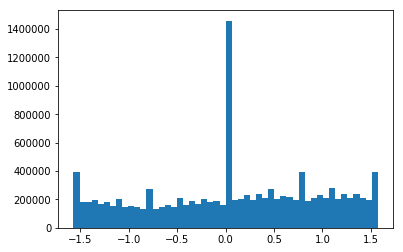

In [45]:
plt.hist(compute_grad_angle(sk.color.rgb2gray(facade_rotated)).flatten(), bins = 50)

4


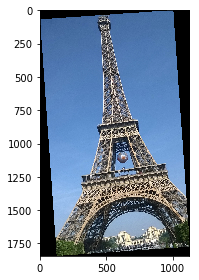

In [75]:
elf = read_im("./demo/elf.jpg")[:,:,:3]
elf_rotated = auto_rotate(elf)
show_im(elf_rotated)

(array([113558.,  17951.,  16258.,  19225.,  19320.,  20006.,  13770.,
         42128.,  13167.,  17009.,  13465.,  13077.,  86577.,  13243.,
         13929.,  17356.,  14077.,  39399.,  15584.,  24179.,  17221.,
         21819.,  19698.,  22367.,  20118., 567209.,  20883.,  19750.,
         24666.,  19279.,  31659.,  20836.,  56572.,  21021.,  28946.,
         23671.,  22281., 128073.,  21210.,  22882.,  30306.,  20330.,
         64878.,  20781.,  31334.,  28806.,  29948.,  22231.,  22289.,
        121661.]),
 array([-1.57069568e+00, -1.50786828e+00, -1.44504088e+00, -1.38221348e+00,
        -1.31938609e+00, -1.25655869e+00, -1.19373129e+00, -1.13090389e+00,
        -1.06807649e+00, -1.00524910e+00, -9.42421697e-01, -8.79594299e-01,
        -8.16766901e-01, -7.53939503e-01, -6.91112105e-01, -6.28284706e-01,
        -5.65457308e-01, -5.02629910e-01, -4.39802512e-01, -3.76975114e-01,
        -3.14147716e-01, -2.51320318e-01, -1.88492920e-01, -1.25665521e-01,
        -6.28381233e-02, -1.

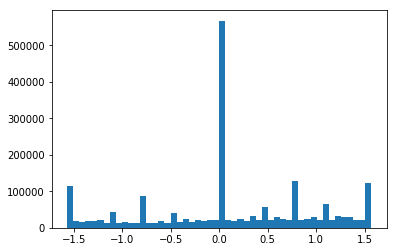

In [76]:
plt.hist(compute_grad_angle(sk.color.rgb2gray(elf_rotated)).flatten(), bins = 50)

6


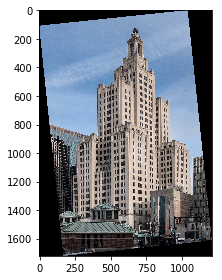

In [77]:
building = read_im("./demo/building.jpg")[:,:,:3]
building_rotated = auto_rotate(building)
show_im(building_rotated)

(array([ 53937.,  23173.,  23913.,  28142.,  23599.,  24750.,  19213.,
         31038.,  18331.,  21970.,  19173.,  16255.,  43434.,  16519.,
         20056.,  23354.,  19975.,  33333.,  22964.,  30760.,  25428.,
         36087.,  36129.,  42716.,  45269., 507750.,  44325.,  40287.,
         43783.,  31725.,  39933.,  32970.,  46183.,  31137.,  35786.,
         32882.,  26576.,  64170.,  26186.,  31678.,  34638.,  29634.,
         44358.,  28777.,  34535.,  30846.,  35936.,  29044.,  25789.,
         53964.]),
 array([-1.57070579e+00, -1.50787844e+00, -1.44505109e+00, -1.38222374e+00,
        -1.31939639e+00, -1.25656903e+00, -1.19374168e+00, -1.13091433e+00,
        -1.06808698e+00, -1.00525963e+00, -9.42432275e-01, -8.79604924e-01,
        -8.16777572e-01, -7.53950220e-01, -6.91122868e-01, -6.28295516e-01,
        -5.65468164e-01, -5.02640812e-01, -4.39813460e-01, -3.76986109e-01,
        -3.14158757e-01, -2.51331405e-01, -1.88504053e-01, -1.25676701e-01,
        -6.28493492e-02, -2.

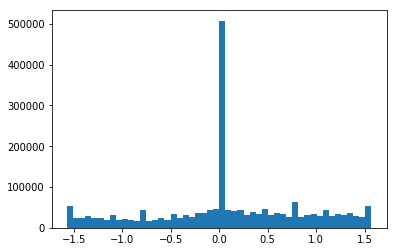

In [78]:
plt.hist(compute_grad_angle(sk.color.rgb2gray(building_rotated)).flatten(), bins = 50)

## Part 2.1: Image "Sharpening"


Helper function for this part

In [79]:
def sharpen(im, alpha):
    """
    the image should be floats
    """
    imb, img, imr = cv2.split(im)
    
    imb_blur = gaussian_filter(imb, 5, 1)
    img_blur = gaussian_filter(img, 5, 1)
    imr_blur = gaussian_filter(imr, 5, 1)
    
    imb_high = imb - imb_blur
    img_high = img - img_blur
    imr_high = imr - imr_blur
    
    imb_sharpen = np.clip(imb + (alpha*imb_high), 0, 1)
    img_sharpen = np.clip(img + (alpha*img_high), 0, 1)
    imr_sharpen = np.clip(imr + (alpha*imr_high), 0, 1)
    
    im_sharpen = stack_channel(imr_sharpen, img_sharpen, imb_sharpen)
    return im_sharpen

Let us try sharpening the taj example. First we load the image

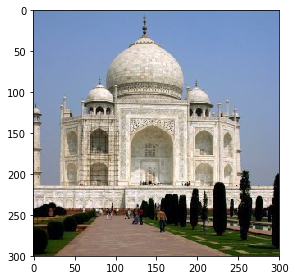

In [82]:
taj = read_im("./demo/taj.jpg")
taj = sk.img_as_float(taj)
show_im(taj)

Now we apply the sharpen function, where we can set the paramter alpha to any factor. And we get the sharpened image.

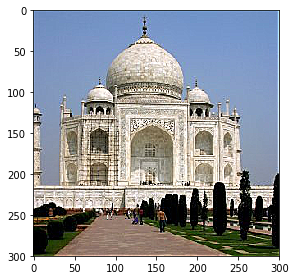

In [83]:
taj_new = sharpen(taj, alpha=2)
show_im(taj_new)

Let's try sharpening on other images of my choice!

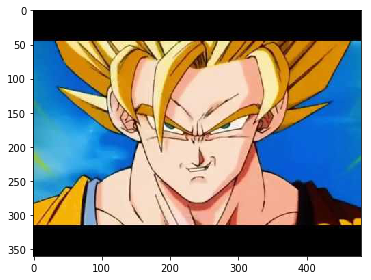

In [84]:
goku = skio.imread("./goku.jpg")
goku = sk.img_as_float(goku)
show_im(goku)

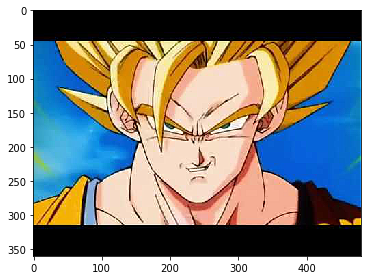

In [85]:
goku_new = sharpen(goku, alpha=1)
show_im(goku_new)

Now let's explore first blurring a very sharp image and then sharpening it. It turns out that we can not achieve the original level of sharpness due to lost of information

In [88]:
messi = skio.imread("./demo/messi.jpg")
messi = sk.img_as_float(messi)
messi_blur = gaussian_filter_color(messi, 15, 5)
messi_new = sharpen(messi_blur, alpha = 3)

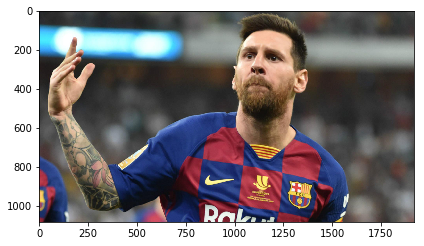

In [89]:
show_im(messi) #original

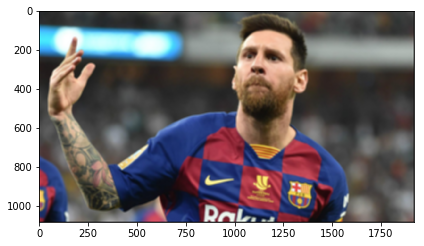

In [90]:
show_im(messi_new) #resharpened version

## Part 2.2 : Hybrid Images

This part of the implementation I did it in the skeleton code. Here is how to use the skeleton code:
- run hybrid_image_starter.py to create hybrid image
- to make a hybrid of any two images, just change the filepath for variable im1 and im2

Here are some helper methods which I used to compute log magnitude for each images

In [101]:
def log_mag_fourier_transform(im, index):
    im_gray = sk.color.rgb2gray(im)
    im_four = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im_gray))))
    im_four = normalize(im_four)
    plt.imshow(im_four)
    print(np.min(im_four))
    skio.imsave("./fourier/" + str(index)+ ".jpg", im_four)
def low_and_high_filter(im1, im2, sigma1, sigma2):

    """
    im1 is the low-freq image
    im2 is the high-freq image
    get high frequency
    :return:
    """
    im1 = sk.color.rgb2gray(im1)
    im2 = sk.color.rgb2gray(im2)

    low_freq = gaussian_filter(im2, 6*sigma1, sigma1)
    im1_blur = gaussian_filter(im1, 6*sigma2, sigma2)
    high_freq = im1 - im1_blur

    return low_freq, high_freq
def log_mag_fourier_transform(im):
    im_gray = sk.color.rgb2gray(im)
    im_four = np.log(np.abs(np.fft.fftshift(np.fft.fft2(im_gray))))
    im_four = normalize(im_four)
    return im_four

Let's try it on the sample images of denero and hilfinger. We compute the log magnitude and display it for the low-frequency hilfinger image and high-frequency denero image

In [94]:
john = skio.imread("./demo/j.jpg")
paul = skio.imread("./demo/h.jpg")

In [95]:
low, high = low_and_high_filter(john, paul, 5, 11)

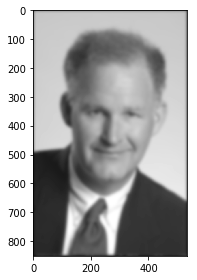

In [103]:
show_im(low)

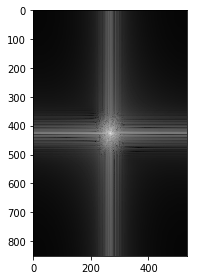

In [104]:
show_im(normalize(log_mag_fourier_transform(low)))

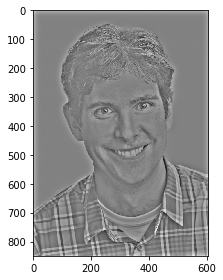

In [106]:
show_im(normalize(high))

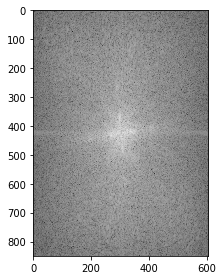

In [107]:
show_im(normalize(log_mag_fourier_transform(high)))

## Part 2.3: Laplacian Pyramid

helper function for 2.3

In [108]:
def gaussian_layers(im, layers, stack):
    if layers == 0:
        return stack
    else:
        if is_color(im):
            gaus_im = gaussian_filter_color(im, 45, 15)
            stack.append(gaus_im)
            return gaussian_layers(gaus_im, layers - 1, stack)
        else:
            gaus_im = gaussian_filter(im, 45, 15)
            stack.append(gaus_im)
            return gaussian_layers(gaus_im, layers - 1, stack)
def gaussian_pyramid(im, layers):
    stack = []
    return gaussian_layers(im, layers, stack)
def is_color(im):
    if len(im.shape) == 3 and im.shape[2] == 3:
        return True
    else:
        return False
def mask_gaussian_pyramid(im, layers, sigma):
    """
    gaussian pyramid for masks
    """
    stack = []
    return mask_gaussian_layers(im, layers, stack,sigma)
def laplacian_stackh(stack):
    return np.hstack(tuple(stack))
def gaussian_filter_color(im, ksize, sigma):
    imb, img, imr = cv2.split(im)
    imb_blur = gaussian_filter(imb, ksize, sigma)
    img_blur = gaussian_filter(img, ksize, sigma)
    imr_blur = gaussian_filter(imr, ksize, sigma)
    return stack_channel(imr_blur, img_blur, imb_blur)
def laplacian_pyramid(im, layers):
    stack_g = gaussian_pyramid(im, layers)
    stack_l = []
    first = im - stack_g[0]
    stack_l.append(first)
    for i in np.arange(len(stack_g)-1):
        laplacian = stack_g[i]-stack_g[i+1]
        stack_l.append(laplacian)
    stack_l.append(stack_g[4])
        
    return stack_l
def mask_gaussian_layers(im, layers, stack, sigma):
    if layers == 0:
        return stack
    else:
        if is_color(im):
            gaus_im = gaussian_filter_color(im, 3*sigma,sigma)
            stack.append(gaus_im)
            return mask_gaussian_layers(gaus_im, layers - 1, stack, sigma)
        else:
            gaus_im = gaussian_filter(im, 3*sigma, sigma)
            stack.append(gaus_im)
            return mask_gaussian_layers(gaus_im, layers - 1, stack, sigma)
def gaussian_stackh(stack):
    return np.hstack(tuple(stack))

Let's compute the gaussian and laplacian stack for the famous lincoln image

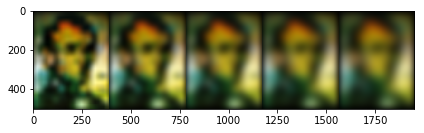

In [109]:
lincoln = skio.imread("./lincoln.jpg")
lincoln_gau_stack = gaussian_pyramid(lincoln, 5)
lincoln_lap_stack = laplacian_pyramid(lincoln, 5)
im150 = laplacian_stackh(lincoln_gau_stack)
skio.imshow(normalize(im150))

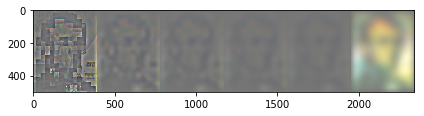

In [110]:
im250 = laplacian_stackh(lincoln_lap_stack)
skio.imshow(normalize(im250))

Now compute the gaussian and laplacian stack for Mona Lisa

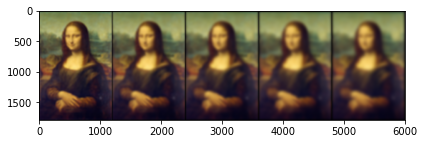

In [111]:
#stack for mona lisa
lisa = skio.imread("./monalisa.jpg")
lisa_gau_stack = gaussian_pyramid(lisa, 5)
lisa_lap_stack = laplacian_pyramid(lisa, 5)
lisa_gau_im = laplacian_stackh(lisa_gau_stack)
lisa_lap_im = laplacian_stackh(lisa_lap_stack)
show_im(normalize(lisa_gau_im))

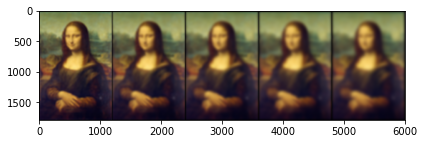

In [112]:
show_im(normalize(lisa_gau_im))

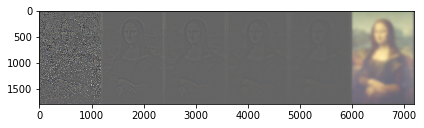

In [113]:
show_im(normalize(lisa_lap_im))

Now let's compute the laplacian stack for one of my favorite hybrid image

In [119]:
hybrid = skio.imread("./good_result/sasuto_3_1.jpg")

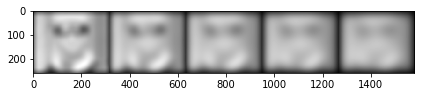

In [120]:
h3 = gaussian_pyramid(hybrid, 5)
h4 = laplacian_stackh(h3)
skio.imshow(normalize(h4))

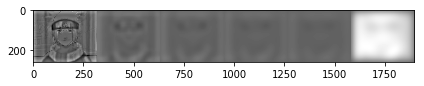

In [121]:
h1 = laplacian_pyramid(hybrid, 5)
h2 = laplacian_stackh(h1)
skio.imshow(normalize(h2))

## Part 2.4: Multiresolution Blending

helper functions for 2.4

In [122]:
def combine_pyramid(LA, LB, layers, mask, sigma):
    mask_size = (LA[0].shape[0],int(LA[0].shape[1]/2))
    mask_gaus_pyramid = mask_gaussian_pyramid(mask, layers+1, sigma)
    LS_pyramid = []
    for i in np.arange(layers+1):
        GR = mask_gaus_pyramid[i]
        LS = apply_weight((1-GR),LA[i]) + apply_weight(GR, LB[i])
        LS_pyramid.append(LS)
    
    return np.sum(LS_pyramid, axis = 0)
def apply_weight(weight, color_im):
    imb, img, imr = cv2.split(color_im)
    imb_weighted = weight * imb
    img_weighted = weight * img
    imr_weighted = weight * imr
    return stack_channel(imr_weighted,img_weighted, imb_weighted)

def blend_im(A, B, layers, mask, sigma):
    LA = laplacian_pyramid(A,layers)
    LB = laplacian_pyramid(B,layers)
    return normalize(combine_pyramid(LA, LB, layers, mask, sigma))

def generate_mask(size):
    black = np.zeros(size)
    white = np.ones(size)
    return np.hstack((black,white))

Let's blend apple and orange! First create laplacian stack for each image

In [123]:
apple = skio.imread("./demo/apple.jpeg")
orange = skio.imread("./demo/orange.jpeg")
LA = laplacian_pyramid(apple,5)
LB = laplacian_pyramid(orange,5)

Now generate mask for the blend

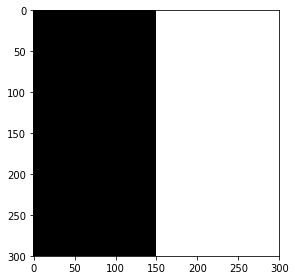

In [124]:
apple_mask =  generate_mask((300, 150))
show_im(apple_mask)

Now blend

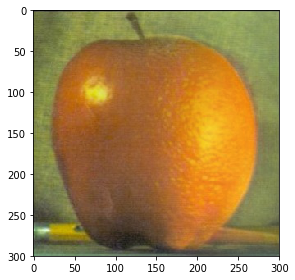

In [125]:
oraple = normalize(combine_pyramid(LA, LB, 5, apple_mask, 60))
show_im(oraple)

Now let's try it on other images using irregular mask

In [129]:
#blending my friend's face with NBA player Kyrie Irving
jeff = skio.imread("./demo/jeff.jpg")
kyrie = skio.imread("./demo/kyrie.jpg")

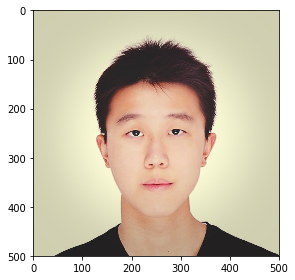

In [130]:
skio.imshow(jeff)

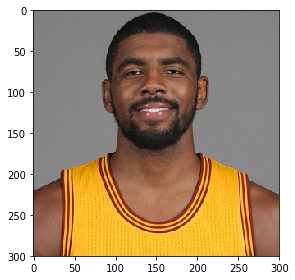

In [131]:
skio.imshow(kyrie)

Manipulate the image so that the faces roughly overlaps when we stack them

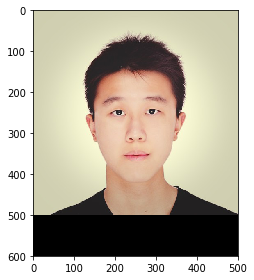

In [132]:
#aligning the faces of the two by hand
jeff_padded = np.vstack(tuple([jeff,np.zeros((100, 500, 3))]))
skio.imshow(normalize(jeff_padded))

In [133]:
#resize them
jeff_resized = normalize(shift_im(jeff_padded, 0, -100))
kyrie_resized = normalize(sktr.resize(kyrie, (600,500,3)))
#generate a mask to blend Jeff and Kyrie
jeff_mask = skio.imread("./demo/jeff_mask.jpg")
jeff_mask = jeff_mask[:,:,:3]
jeff_mask = normalize(sktr.resize(jeff_mask, (600,500,3)))
jeff_mask = sk.color.rgb2gray(jeff_mask)

/Users/princewang/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/princewang/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


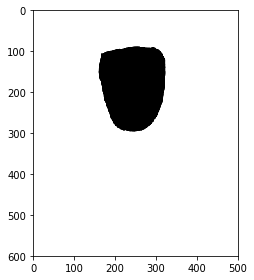

In [134]:
skio.imshow(jeff_mask)

Now we blend the two

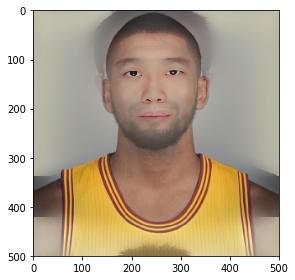

In [135]:
jyrie = blend_im(shift_im(jeff_resized, -5,5), kyrie_resized,5, jeff_mask, 40)
jyrie = sktr.resize(normalize(jyrie),(500,500,3))
skio.imshow(jyrie)

let's try blending a basketball and a football

In [272]:
#load images
soccer = sktr.resize(skio.imread("./demo/soccer.jpg"), (400,400,3))
basketball = sktr.resize(skio.imread("./demo/basketball.jpg"), (400,400,3))

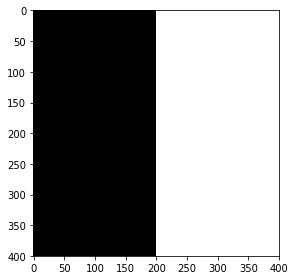

In [273]:
#generate mask
bball_mask = generate_mask((400,200))
skio.imshow(bball_mask)

In [277]:
#merge the two
bf = blend_im(soccer, basketball,5, bball_mask, 20)

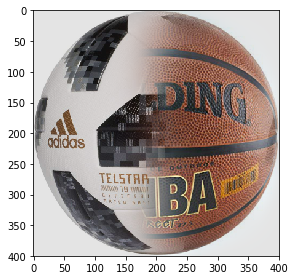

In [278]:
skio.imshow(bf)

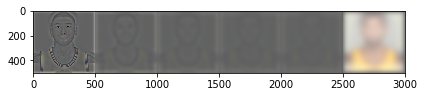

In [136]:
#applying the laplacian stack to my favorite result
fav = skio.imread("./demo/jyrie.jpg")
fav_lap = laplacian_pyramid(fav, 5)
fav_im = laplacian_stackh(fav_lap)
show_im(normalize(fav_im))

# The end, thanks for grading!